출처;

https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0 <br>
http://bcho.tistory.com/1195

In [4]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data as mnist_data
from tensorflow.contrib import slim
from tensorflow.contrib.learn import ModeKeys
from tensorflow.contrib.learn import learn_runner

# Estimator

Class이며, 모델, 학습 평가 될 사항들은 정함 input, Labels를 주면 train/eval/predict/export를 진행

Pass사항은 3가지가 필요

- parameter: 모델의 파라미터의 집합이어야 하며, dictionary가 될 수 도 있지만, HParams object (namedtuple)의 예로 보여주려함
- configuration: 학습이 어떻게 평가되고 실행되는지 체크 후, 결과를 저장까지 시킴. RunConfig object에 진행됨. (Estimator가 학습에 필요한 모든 환경들을 실행한다.)
- model function: python function이며, input을 기반으로 모델을 생성한다.

In [ ]:
return tf.estimator.Estimator(
        model_fn = model_fn, #first class function
        params = params, #HPramas
        config = run_config # Run Config
)

# Estimator 예제

In [8]:
import numpy as np

#데이터생성
num_points = 300
vectors_set = []
for i in range(num_points):
    x = np.random.normal(5,5)+15
    y =  x*2+ (np.random.normal(0,3))*2
    vectors_set.append([x,y])

x_data = [v[0] for v in vectors_set]
y_data = [v[1] for v in vectors_set]

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


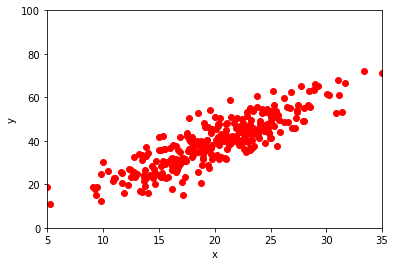

In [10]:
#시각화
import matplotlib.pyplot as plt

plt.plot(x_data,y_data,'ro')
plt.ylim([0,100])
plt.xlim([5,35])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Model function

모델 함수는 Estimator의 first class function이다. 이에 대한 장점은 함수가 instantiating 될 때마다 반응 할 수 있다는 것.<br>
이게 무슨 뜻이냐 하면, 모델이 학습 중에 다양한 input을 받을 수 있다는 의미다. 예를 들면, training중에 validation testing을 동시에 할 수 있다는 것이다.<br>
모델 funtion이 입력 받는것은 아래와 같으며, 모든 것은 __EstimatorSpec__ object로 return을 받아 모델을 완성시킵니다. <br>
EstimatorSpec은 prediction, loss, training, evaluation operation들을 받아 full model graph에서 training, evaluation, inference를 진행힙니다. 또, EstimatorSpec은 일반적인 Tensorflow Operations를 받기 대문에, tf-slim과 같은 모델로 define 할 수 있습니다. <br>
- input features: parameters
- labels: tensor형태
- mode: model이 학습인지 평간지, 추론을 하는 것인지 확인 하기 위한 것
- hyperparameters: 파라메터를 받아야함



* first class function
 - 1급 시민의 조건인, 변수를 담을수 있고, 인자 전달이 가능하며, 반환값을 전달하는 것에, 런타임 생성과 익명 생성이 추가 된 것


## Estimator 예제

In [13]:
#numpy 배열에서 데이터를 읽어서 리턴하기
#x,y학습 데이터200까지 사용하고, 학습 epoch와 배치 사이즈를 정의 + 랜덤 셔플처리
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x = {"x":np.array(x_data[:200], dtype=np.float32)},
    y = np.array(y_data[:200], dtype=np.float32),
    num_epochs = 10000,
    batch_size = 50,
    shuffle = True
)

input_fn_eval = tf.estimator.inputs.numpy_input_fn(
    x = {"x":np.array(x_data[200:300], dtype=np.float32)},
    y = np.array(y_data[200:300], dtype=np.float32),
    num_epochs = 10000,
    batch_size = 50,
    shuffle = True
)

input_fn_predict = tf.estimator.inputs.numpy_input_fn(
    x = {"x":np.array([15,20,25,30], dtype=np.float32)},
    num_epochs = 1,
    shuffle = False
)

# Modeling
# 읽어온 데이터에서, 어떤 컬럼을 학습에 사용할 지, 컬럼의 데이터 입력 (연속형 및 분류형)을 정한다.
# 컬럼 명 x를 학습 데이터로 사용하고 x는 연속형 변수로 지정

column_x = tf.feature_column.numeric_column("x", dtype=tf.float32)
columns = [column_x]

#col.에 사용할 피쳐 목록이다.

estimator = tf.contrib.learn.LinearRegressor(feature_columns=columns, optimizer="Adam")

#학습 및 예측
#학습은 .fit이란 method를 사용
estimator.fit(input_fn = input_fn_train, steps=5000)
estimator.evaluate(input_fn = input_fn_eval,steps=10)
result = list(estimator.predict(input_fn = input_fn_predict))

## 조금 더 쉽게 변경 해 보자

In [21]:
def input_fn():
    features = tf.constant(x_data, tf.float32)
    label = tf.constant(y_data, tf.float32)
    return features, label

def model(features, labels, mode):
    layer1 = tf.layers.dense(features, 10)
    layer2 = tf.layers.dense(layer1, 10)
    out = tf.layers.dense(layer2, 1)
    
    global_step = tf.train.get_global_step()
    loss = tf.losses.sigmoid_cross_entropy(labels, out)
    train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)
    
    return tf.estimator.EstimatorSpec(mode = mode, loss=loss, train_op=train_op)

est = tf.estimator.Estimator(model)
est.train(input_fn, steps = 5)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ty/43yv2fzx4l9df6zcch8zml6m0000gn/T/tmpo13upsvx', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


ValueError: Input 0 of layer dense_1 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: [300]

In [ ]:

# -*- coding: utf-8 -*-

import tensorflow as tf 
import numpy as np 
import csv 
import os 
from sklearn import utils 
import os
import re




tf.logging.set_verbosity(tf.logging.INFO)


def parser(serialized_example):
    features = {'sequence': tf.FixedLenFeature([2429], tf.int64), 
            'species': tf.FixedLenFeature([1], tf.int64)}

    parsed_feature = tf.parse_single_example(serialized_example, features)
    sequence = tf.cast(parsed_feature['sequence'], tf.int32)
    species = tf.cast(parsed_feature['species'], tf.int32)
    return sequence, species


def input_fn_train(): 
    
    ap = re.compile('dataset') # 발췌할 문자열 기입
    file_dir= './dataset' # 데이터 경로 
    files = os.listdir('./dataset/') # 경로에 해당하는 전체 파일들 
      
    train_data_all = list(filter(ap.search, files)) # 전체 파일들 중 발췌대상 문자열과 일치하는 파일들을 list 형태로 (데이터셋 10개)
    
    print("train:", train_data_all)
    
    # 발췌된 전체 train_dataset 의 리스트 중 하나씩 빼온 것이 train_data. 이것이 데이터경로와 join 되어 filename 형성 
    filename = [os.path.join(file_dir, train_data) for train_data in train_data_all]
    filename.sort() 
    filename = filename[:8]
    print("filename1:",filename)
    dataset = tf.contrib.data.TFRecordDataset(filename).map(parser)
    dataset = dataset.batch(1000)
    itr = dataset.make_one_shot_iterator()

    sequence, species  = itr.get_next()

    train_data = tf.one_hot(indices=sequence, depth=4)# depth 가 가로 길이 (종류)
    train_label = tf.one_hot(indices=species,depth=11)


    return train_data, train_label


def input_fn_test():
    
    p = re.compile('dataset') # 발췌할 문자열 기입
    file_dir= './dataset' # 데이터 경로 
    files = os.listdir('./dataset/') # 경로에 해당하는 전체 파일들 
    test_data_all = list(filter(p.match, files)) # 전체 파일들 중 발췌대상 문자열과 일치하는 파일들을 list 형태로 (데이터셋 10개)

    print("test:", test_data_all)
    # 발췌된 전체 train_dataset 의 리스트 중 하나씩 빼온 것이 train_data. 이것이 데이터경로와 join 되어 filename 형성 
    filename = [os.path.join(file_dir, train_data) for train_data in test_data_all]
    filename.sort()  
    filename = filename[8:]
    print("filename2:",filename)
    dataset = tf.contrib.data.TFRecordDataset(filename).map(parser)
    dataset = dataset.batch(1000)
    itr = dataset.make_one_shot_iterator()

    sequence, species  = itr.get_next()

    test_data = tf.one_hot(indices=sequence, depth=4)# depth 가 가로 길이 (종류)
    test_label = tf.one_hot(indices=species,depth=11)

    return test_data, test_label



def model_fn(features, labels, mode): 

    """ model function for estimator """ 
    train_op = None 
    loss = None 
    val_metric_ops = None

   # filters = # of kernels ,  kernel_size = window size 
    conv1 = tf.layers.conv1d(features, filters=16, kernel_size=24, padding="SAME")
    maxpool = tf.layers.max_pooling1d(conv1,2429,strides=1)
    fc = tf.layers.dense(maxpool, 32)
    out = tf.layers.dense(fc,11) 

    print("out:",out)

    # mode = prediction
    if mode == tf.estimator.ModeKeys.PREDICT: 
        return tf.estimator.EstimatorSpec( 
            mode=mode, 
            predictions={
                "prob":tf.nn.softmax(out)})

    # mode = training
    else: 
        global_step = tf.train.get_global_step() 
        loss = tf.losses.softmax_cross_entropy(labels, out) 
        train_op = tf.train.GradientDescentOptimizer(1e-2).minimize(loss, global_step) 
        accuracy = tf.metrics.accuracy(labels, tf.round(tf.nn.softmax(out))) 
        eval_metric_ops = {"acc": accuracy} 
        

        return tf.estimator.EstimatorSpec( 
            mode=mode, 
            train_op=train_op, 
            loss=loss, 
            eval_metric_ops=eval_metric_ops) 




est = tf.estimator.Estimator(model_fn) 


for epoch in range(1): 
    est.train(input_fn_train,steps=3) 
    est.evaluate(input_fn_test,steps=3)

# Experiement

Experiement는 train model이 Estimator와 integrates를 할 수 있는 지 제공합니다. <br>

input 리스트
- estimator: 위에 설명
- Train and eval. data as first class func: operation대신 function을 받으므로써 재생산이 가능함.
- training and eval hooks: save 나 모니터링을 하는 곳에 쓰인다.
- 그 외 트레인을 얼마나 할지 그 외의 것들을 받음

그 이후, train과 eval을 learn_runner.run으로 받는다

In [ ]:
experiments = tf.contrib.learn.Experiment(
        estimator = estimator,
        train_input_fn = train_input_fn, #1st class fun
        eval_input_fn = eval_input_fn,
        train_steps = params.train_steps, #minibatch steps
        min_eval_frequency=params.min_eval_frequency, #eval freq
        train_monitors=[train_input, hook], #hooks for training
        eval_steps=None #use eval. feeder until its empty
)

In [ ]:
learn_runner.run(
    experiment_fn=experiment_fn,  # First-class function
    run_config=run_config,  # RunConfig
    schedule="train_and_evaluate",  # What to run
    hparams=params  # HParams
)

# Dataset

MNIST를 Dataset클레스와 Iterator를 사용하여 데이터를 학습시키고 할 것임.

In [ ]:
# Define the training inputs
def get_train_inputs(batch_size, mnist_data):
    """Return the input function to get the training data.
    Args:
        batch_size (int): Batch size of training iterator that is returned
                          by the input function.
        mnist_data (Object): Object holding the loaded mnist data.
    Returns:
        (Input function, IteratorInitializerHook):
            - Function that returns (features, labels) when called.
            - Hook to initialise input iterator.
    """
    iterator_initializer_hook = IteratorInitializerHook()

    def train_inputs():
        """Returns training set as Operations.
        Returns:
            (features, labels) Operations that iterate over the dataset
            on every evaluation
        """
        with tf.name_scope('Training_data'):
            # Get Mnist data
            images = mnist_data.train.images.reshape([-1, 28, 28, 1])
            labels = mnist_data.train.labels
            # Define placeholders
            images_placeholder = tf.placeholder(
                images.dtype, images.shape)
            labels_placeholder = tf.placeholder(
                labels.dtype, labels.shape)
            # Build dataset iterator
            dataset = tf.contrib.data.Dataset.from_tensor_slices(
                (images_placeholder, labels_placeholder))
            dataset = dataset.repeat(None)  # Infinite iterations
            dataset = dataset.shuffle(buffer_size=10000)
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_initializable_iterator()
            next_example, next_label = iterator.get_next()
            # Set runhook to initialize iterator
            iterator_initializer_hook.iterator_initializer_func = \
                lambda sess: sess.run(
                    iterator.initializer,
                    feed_dict={images_placeholder: images,
                               labels_placeholder: labels})
            # Return batched (features, labels)
            return next_example, next_label

    # Return function and hook
    return train_inputs, iterator_initializer_hook

In [ ]:
class IteratorInitializerHook(tf.train.SessionRunHook):
    """Hook to initialise data iterator after Session is created."""

    def __init__(self):
        super(IteratorInitializerHook, self).__init__()
        self.iterator_initializer_func = None

    def after_create_session(self, session, coord):
        """Initialise the iterator after the session has been created."""
        self.iterator_initializer_func(session)

# Full Code

In [3]:
"""Script to illustrate usage of tf.estimator.Estimator in TF v1.3"""

# Show debugging output
tf.logging.set_verbosity(tf.logging.DEBUG)

# Set default flags for the output directories
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string(
    flag_name='model_dir', default_value='./mnist_training',
    docstring='Output directory for model and training stats.')
tf.app.flags.DEFINE_string(
    flag_name='data_dir', default_value='./mnist_data',
    docstring='Directory to download the data to.')


# Define and run experiment ###############################
def run_experiment(argv=None):
    """Run the training experiment."""
    # Define model parameters
    params = tf.contrib.training.HParams(
        learning_rate=0.002,
        n_classes=10,
        train_steps=5000,
        min_eval_frequency=100
    )

    # Set the run_config and the directory to save the model and stats
    run_config = tf.contrib.learn.RunConfig()
    run_config = run_config.replace(model_dir=FLAGS.model_dir)

    learn_runner.run(
        experiment_fn=experiment_fn,  # First-class function
        run_config=run_config,  # RunConfig
        schedule="train_and_evaluate",  # What to run
        hparams=params  # HParams
    )


def experiment_fn(run_config, params):
    """Create an experiment to train and evaluate the model.
    Args:
        run_config (RunConfig): Configuration for Estimator run.
        params (HParam): Hyperparameters
    Returns:
        (Experiment) Experiment for training the mnist model.
    """
    # You can change a subset of the run_config properties as
    run_config = run_config.replace(
        save_checkpoints_steps=params.min_eval_frequency)
    # Define the mnist classifier
    estimator = get_estimator(run_config, params)
    # Setup data loaders
    mnist = mnist_data.read_data_sets(FLAGS.data_dir, one_hot=False)
    train_input_fn, train_input_hook = get_train_inputs(
        batch_size=128, mnist_data=mnist)
    eval_input_fn, eval_input_hook = get_test_inputs(
        batch_size=128, mnist_data=mnist)
    # Define the experiment
    experiment = tf.contrib.learn.Experiment(
        estimator=estimator,  # Estimator
        train_input_fn=train_input_fn,  # First-class function
        eval_input_fn=eval_input_fn,  # First-class function
        train_steps=params.train_steps,  # Minibatch steps
        min_eval_frequency=params.min_eval_frequency,  # Eval frequency
        train_monitors=[train_input_hook],  # Hooks for training
        eval_hooks=[eval_input_hook],  # Hooks for evaluation
        eval_steps=None  # Use evaluation feeder until its empty
    )
    return experiment


# Define model ############################################
def get_estimator(run_config, params):
    """Return the model as a Tensorflow Estimator object.
    Args:
         run_config (RunConfig): Configuration for Estimator run.
         params (HParams): hyperparameters.
    """
    return tf.estimator.Estimator(
        model_fn=model_fn,  # First-class function
        params=params,  # HParams
        config=run_config  # RunConfig
    )


def model_fn(features, labels, mode, params):
    """Model function used in the estimator.
    Args:
        features (Tensor): Input features to the model.
        labels (Tensor): Labels tensor for training and evaluation.
        mode (ModeKeys): Specifies if training, evaluation or prediction.
        params (HParams): hyperparameters.
    Returns:
        (EstimatorSpec): Model to be run by Estimator.
    """
    is_training = mode == ModeKeys.TRAIN
    # Define model's architecture
    logits = architecture(features, is_training=is_training)
    predictions = tf.argmax(logits, axis=-1)
    # Loss, training and eval operations are not needed during inference.
    loss = None
    train_op = None
    eval_metric_ops = {}
    if mode != ModeKeys.INFER:
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels=tf.cast(labels, tf.int32),
            logits=logits)
        train_op = get_train_op_fn(loss, params)
        eval_metric_ops = get_eval_metric_ops(labels, predictions)
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops
    )


def get_train_op_fn(loss, params):
    """Get the training Op.
    Args:
         loss (Tensor): Scalar Tensor that represents the loss function.
         params (HParams): Hyperparameters (needs to have `learning_rate`)
    Returns:
        Training Op
    """
    return tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        optimizer=tf.train.AdamOptimizer,
        learning_rate=params.learning_rate
    )


def get_eval_metric_ops(labels, predictions):
    """Return a dict of the evaluation Ops.
    Args:
        labels (Tensor): Labels tensor for training and evaluation.
        predictions (Tensor): Predictions Tensor.
    Returns:
        Dict of metric results keyed by name.
    """
    return {
        'Accuracy': tf.metrics.accuracy(
            labels=labels,
            predictions=predictions,
            name='accuracy')
    }


def architecture(inputs, is_training, scope='MnistConvNet'):
    """Return the output operation following the network architecture.
    Args:
        inputs (Tensor): Input Tensor
        is_training (bool): True iff in training mode
        scope (str): Name of the scope of the architecture
    Returns:
         Logits output Op for the network.
    """
    with tf.variable_scope(scope):
        with slim.arg_scope(
                [slim.conv2d, slim.fully_connected],
                weights_initializer=tf.contrib.layers.xavier_initializer()):
            net = slim.conv2d(inputs, 20, [5, 5], padding='VALID',
                              scope='conv1')
            net = slim.max_pool2d(net, 2, stride=2, scope='pool2')
            net = slim.conv2d(net, 40, [5, 5], padding='VALID',
                              scope='conv3')
            net = slim.max_pool2d(net, 2, stride=2, scope='pool4')
            net = tf.reshape(net, [-1, 4 * 4 * 40])
            net = slim.fully_connected(net, 256, scope='fn5')
            net = slim.dropout(net, is_training=is_training,
                               scope='dropout5')
            net = slim.fully_connected(net, 256, scope='fn6')
            net = slim.dropout(net, is_training=is_training,
                               scope='dropout6')
            net = slim.fully_connected(net, 10, scope='output',
                                       activation_fn=None)
        return net


# Define data loaders #####################################
class IteratorInitializerHook(tf.train.SessionRunHook):
    """Hook to initialise data iterator after Session is created."""

    def __init__(self):
        super(IteratorInitializerHook, self).__init__()
        self.iterator_initializer_func = None

    def after_create_session(self, session, coord):
        """Initialise the iterator after the session has been created."""
        self.iterator_initializer_func(session)


# Define the training inputs
def get_train_inputs(batch_size, mnist_data):
    """Return the input function to get the training data.
    Args:
        batch_size (int): Batch size of training iterator that is returned
                          by the input function.
        mnist_data (Object): Object holding the loaded mnist data.
    Returns:
        (Input function, IteratorInitializerHook):
            - Function that returns (features, labels) when called.
            - Hook to initialise input iterator.
    """
    iterator_initializer_hook = IteratorInitializerHook()

    def train_inputs():
        """Returns training set as Operations.
        Returns:
            (features, labels) Operations that iterate over the dataset
            on every evaluation
        """
        with tf.name_scope('Training_data'):
            # Get Mnist data
            images = mnist_data.train.images.reshape([-1, 28, 28, 1])
            labels = mnist_data.train.labels
            # Define placeholders
            images_placeholder = tf.placeholder(
                images.dtype, images.shape)
            labels_placeholder = tf.placeholder(
                labels.dtype, labels.shape)
            # Build dataset iterator
            dataset = tf.contrib.data.Dataset.from_tensor_slices(
                (images_placeholder, labels_placeholder))
            dataset = dataset.repeat(None)  # Infinite iterations
            dataset = dataset.shuffle(buffer_size=10000)
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_initializable_iterator()
            next_example, next_label = iterator.get_next()
            # Set runhook to initialize iterator
            iterator_initializer_hook.iterator_initializer_func = \
                lambda sess: sess.run(
                    iterator.initializer,
                    feed_dict={images_placeholder: images,
                               labels_placeholder: labels})
            # Return batched (features, labels)
            return next_example, next_label

    # Return function and hook
    return train_inputs, iterator_initializer_hook


def get_test_inputs(batch_size, mnist_data):
    """Return the input function to get the test data.
    Args:
        batch_size (int): Batch size of training iterator that is returned
                          by the input function.
        mnist_data (Object): Object holding the loaded mnist data.
    Returns:
        (Input function, IteratorInitializerHook):
            - Function that returns (features, labels) when called.
            - Hook to initialise input iterator.
    """
    iterator_initializer_hook = IteratorInitializerHook()

    def test_inputs():
        """Returns training set as Operations.
        Returns:
            (features, labels) Operations that iterate over the dataset
            on every evaluation
        """
        with tf.name_scope('Test_data'):
            # Get Mnist data
            images = mnist_data.test.images.reshape([-1, 28, 28, 1])
            labels = mnist_data.test.labels
            # Define placeholders
            images_placeholder = tf.placeholder(
                images.dtype, images.shape)
            labels_placeholder = tf.placeholder(
                labels.dtype, labels.shape)
            # Build dataset iterator
            dataset = tf.contrib.data.Dataset.from_tensor_slices(
                (images_placeholder, labels_placeholder))
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_initializable_iterator()
            next_example, next_label = iterator.get_next()
            # Set runhook to initialize iterator
            iterator_initializer_hook.iterator_initializer_func = \
                lambda sess: sess.run(
                    iterator.initializer,
                    feed_dict={images_placeholder: images,
                               labels_placeholder: labels})
            return next_example, next_label

    # Return function and hook
    return test_inputs, iterator_initializer_hook


# Run script ##############################################
if __name__ == "__main__":
    tf.app.run(
        main=run_experiment
    )

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x120dc0f98>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 100, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './mnist_training'}
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./mnist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Successfully down

INFO:tensorflow:Restoring parameters from ./mnist_training/model.ckpt-1101
INFO:tensorflow:Finished evaluation at 2017-09-21-15:20:18
INFO:tensorflow:Saving dict for global step 1101: Accuracy = 0.9899, global_step = 1101, loss = 0.0338598
INFO:tensorflow:Validation (step 1200): Accuracy = 0.9899, loss = 0.0338598, global_step = 1101
INFO:tensorflow:Saving checkpoints for 1201 into ./mnist_training/model.ckpt.
INFO:tensorflow:global_step/sec: 9.42215
INFO:tensorflow:loss = 0.0649293, step = 1201 (10.613 sec)
INFO:tensorflow:Starting evaluation at 2017-09-21-15:20:27
INFO:tensorflow:Restoring parameters from ./mnist_training/model.ckpt-1201
INFO:tensorflow:Finished evaluation at 2017-09-21-15:20:29
INFO:tensorflow:Saving dict for global step 1201: Accuracy = 0.9898, global_step = 1201, loss = 0.0362467
INFO:tensorflow:Validation (step 1300): Accuracy = 0.9898, loss = 0.0362467, global_step = 1201
INFO:tensorflow:Saving checkpoints for 1301 into ./mnist_training/model.ckpt.
INFO:tensorfl

INFO:tensorflow:Validation (step 2600): Accuracy = 0.9931, loss = 0.0237308, global_step = 2501
INFO:tensorflow:Saving checkpoints for 2601 into ./mnist_training/model.ckpt.
INFO:tensorflow:global_step/sec: 9.90597
INFO:tensorflow:loss = 0.00928678, step = 2601 (10.095 sec)
INFO:tensorflow:Starting evaluation at 2017-09-21-15:22:45
INFO:tensorflow:Restoring parameters from ./mnist_training/model.ckpt-2601
INFO:tensorflow:Finished evaluation at 2017-09-21-15:22:47
INFO:tensorflow:Saving dict for global step 2601: Accuracy = 0.9926, global_step = 2601, loss = 0.0298234
INFO:tensorflow:Validation (step 2700): Accuracy = 0.9926, loss = 0.0298234, global_step = 2601
INFO:tensorflow:Saving checkpoints for 2701 into ./mnist_training/model.ckpt.
INFO:tensorflow:global_step/sec: 10.1001
INFO:tensorflow:loss = 0.0220058, step = 2701 (9.901 sec)
INFO:tensorflow:Starting evaluation at 2017-09-21-15:22:55
INFO:tensorflow:Restoring parameters from ./mnist_training/model.ckpt-2701
INFO:tensorflow:Fin

KeyboardInterrupt: 

In [ ]:
"""Script to illustrate inference of a trained tf.estimator.Estimator.
NOTE: This is dependent on mnist_estimator.py which defines the model.
mnist_estimator.py can be found at:
https://gist.github.com/peterroelants/9956ec93a07ca4e9ba5bc415b014bcca
"""
import numpy as np
import skimage.io
import tensorflow as tf

from mnist_estimator import get_estimator


# Set default flags for the output directories
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string(
    flag_name='saved_model_dir', default_value='./mnist_training',
    docstring='Output directory for model and training stats.')


# MNIST sample images
IMAGE_URLS = [
    'https://i.imgur.com/SdYYBDt.png',  # 0
    'https://i.imgur.com/Wy7mad6.png',  # 1
    'https://i.imgur.com/nhBZndj.png',  # 2
    'https://i.imgur.com/V6XeoWZ.png',  # 3
    'https://i.imgur.com/EdxBM1B.png',  # 4
    'https://i.imgur.com/zWSDIuV.png',  # 5
    'https://i.imgur.com/Y28rZho.png',  # 6
    'https://i.imgur.com/6qsCz2W.png',  # 7
    'https://i.imgur.com/BVorzCP.png',  # 8
    'https://i.imgur.com/vt5Edjb.png',  # 9
]


def infer(argv=None):
    """Run the inference and print the results to stdout."""
    params = tf.contrib.training.HParams()  # Empty hyperparameters
    # Set the run_config where to load the model from
    run_config = tf.contrib.learn.RunConfig()
    run_config = run_config.replace(model_dir=FLAGS.saved_model_dir)
    # Initialize the estimator and run the prediction
    estimator = get_estimator(run_config, params)
    result = estimator.predict(input_fn=test_inputs)
    for r in result:
        print(r)


def test_inputs():
    """Returns training set as Operations.
    Returns:
        (features, ) Operations that iterate over the test set.
    """
    with tf.name_scope('Test_data'):
        images = tf.constant(load_images(), dtype=np.float32)
        dataset = tf.contrib.data.Dataset.from_tensor_slices((images,))
        # Return as iteration in batches of 1
        return dataset.batch(1).make_one_shot_iterator().get_next()


def load_images():
    """Load MNIST sample images from the web and return them in an array.
    Returns:
        Numpy array of size (10, 28, 28, 1) with MNIST sample images.
    """
    images = np.zeros((10, 28, 28, 1))
    for idx, url in enumerate(IMAGE_URLS):
        images[idx, :, :, 0] = skimage.io.imread(url)
    return images


# Run script ##############################################
if __name__ == "__main__":
    tf.app.run(main=infer)